# CTA 4.0 - Optimization 1.0

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from cvx.simulator import FuturesPortfolio
from cvx.simulator import interpolate

from tinycta.signal import *


In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True)

# interpolate the prices
prices = prices.apply(interpolate)


In [3]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox([Label("Fast Moving Average"), Label("Slow Moving Average"), Label("Volatility"), Label("Winsorizing")])
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [4]:
mu = np.tanh(prices.apply(returns_adjust, com=vola.value, clip=winsor.value).cumsum().apply(osc, fast=fast.value, slow=slow.value))
volax = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std()

# compute the series of Euclidean norms by compute the sum of squares for each row
euclid_norm = np.sqrt((mu*mu).sum(axis=1))

# Divide each column of mu by the Euclidean norm
risk_scaled = mu.apply(lambda x: x/euclid_norm, axis=0)

pos = 5e5*risk_scaled/volax
portfolio = FuturesPortfolio.from_cashpos_prices(prices=prices, cashposition=pos, aum=1e8)

/Users/a13069q/github/cs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


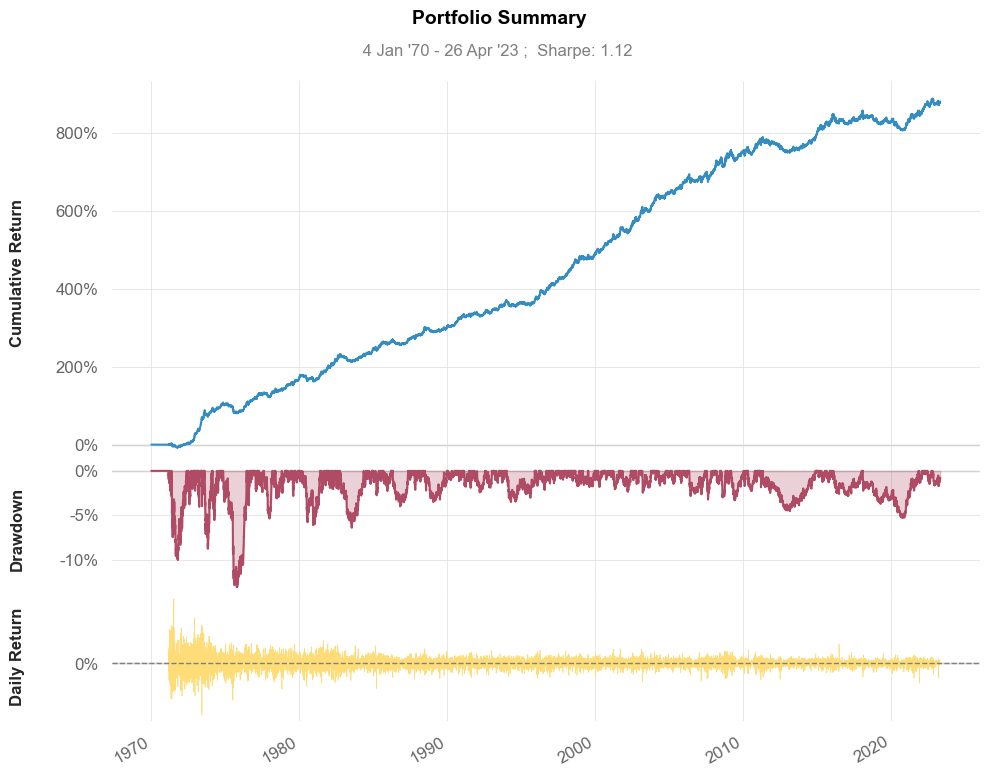

In [5]:
portfolio.snapshot()

In [6]:
pd.set_option('display.precision', 2)
portfolio.metrics()

                    Strategy
------------------  ----------
Start Period        1970-01-05
End Period          2023-04-26
Risk-Free Rate      0.0%
Time in Market      97.0%

Cumulative Return   880.06%
CAGR﹪              3.0%

Sharpe              1.12
Prob. Sharpe Ratio  100.0%
Sortino             1.68
Sortino/√2          1.19
Omega               1.24

Max Drawdown        -13.12%
Longest DD Days     1471

Gain/Pain Ratio     0.24
Gain/Pain (1M)      1.5

Payoff Ratio        1.03
Profit Factor       1.24
Common Sense Ratio  1.32
CPC Index           0.7
Tail Ratio          1.07
Outlier Win Ratio   4.73
Outlier Loss Ratio  4.15

MTD                 0.37%
3M                  0.68%
6M                  -0.43%
YTD                 0.32%
1Y                  0.97%
3Y (ann.)           1.48%
5Y (ann.)           0.56%
10Y (ann.)          0.93%
All-time (ann.)     3.0%

Avg. Drawdown       -0.68%
Avg. Drawdown Days  33
Recovery Factor     17.7
Ulcer Index         0.02
Serenity Index      4.77
